In [470]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline



**Import Sample orders data containing transactions** 

In [471]:

dataset = pd.read_csv('sample-orders.csv',encoding = 'unicode_escape')
dataset.head()



,order_date,order_id,customer,grand_total
0,9/7/11,CA-2011-100006,Dennis Kane,378
1,7/8/11,CA-2011-100090,Ed Braxton,699
2,3/14/11,CA-2011-100293,Neil Franzsisch,91
3,1/29/11,CA-2011-100328,Jasper Cacioppo,4
4,4/8/11,CA-2011-100363,Jim Mitchum,21


# Create the RFM

Setting this date to the current day and extracting all orders until yesterday

In [472]:
rec = dt.datetime(2020, 9, 25)

Make the date_placed column datetime

In [473]:
dataset['order_date'] = pd.to_datetime(dataset['order_date'])

In [474]:
dataset.head()

,order_date,order_id,customer,grand_total
0,2011-09-07,CA-2011-100006,Dennis Kane,378
1,2011-07-08,CA-2011-100090,Ed Braxton,699
2,2011-03-14,CA-2011-100293,Neil Franzsisch,91
3,2011-01-29,CA-2011-100328,Jasper Cacioppo,4
4,2011-04-08,CA-2011-100363,Jim Mitchum,21


Create the RFM Table

In [475]:
RMF_Table = dataset.groupby('customer').agg({'order_date': lambda x: (rec - x.max()).days, # Recency
                                        'order_id': lambda x: len(x),      # Frequency
                                        'grand_total': lambda x: x.sum()}) # Monetary Value

RMF_Table['order_date'] = RMF_Table['order_date'].astype(int)
RMF_Table.rename(columns={'order_date': 'recency', 
                         'order_id': 'frequency', 
                         'grand_total': 'monetary_value'}, inplace=True)

RMF TABLE

In [476]:
RMF_Table.head()

,recency,frequency,monetary_value
customer,,,
Aaron Bergman,2510,3,887
Aaron Hawkins,2107,7,1744
Aaron Smayling,2183,7,3050
Adam Bellavance,2149,8,7756
Adam Hart,2129,10,3249


#Determining RFM Quartiles

In [477]:
quantiles = RMF_Table.quantile(q=[0.25,0.5,0.75])

In [478]:
quantiles

,recency,frequency,monetary_value
0.25,2125.0,5.0,1145.0
0.50,2170.0,6.0,2257.0
0.75,2278.0,8.0,3784.0


Send quantiles to a dictionary

In [479]:
quantiles = quantiles.to_dict()


In [480]:
quantiles

{'frequency': {0.25: 5.0, 0.5: 6.0, 0.75: 8.0},
 'monetary_value': {0.25: 1145.0, 0.5: 2257.0, 0.75: 3784.0},
 'recency': {0.25: 2125.0, 0.5: 2170.0, 0.75: 2278.0}}

#Creating the RFM segmentation table

In [481]:
RMF_Segmentation = RMF_Table

created a class for the RFM segmentation where: 4 is best and 1 is bad

---



In [482]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RmfClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [483]:
RMF_Segmentation['R'] = RMF_Segmentation['recency'].apply(RmfClass, args=('recency',quantiles,))
RMF_Segmentation['F'] = RMF_Segmentation['frequency'].apply(RmfClass, args=('frequency',quantiles,))
RMF_Segmentation['M'] = RMF_Segmentation['monetary_value'].apply(RmfClass, args=('monetary_value',quantiles,))

In [484]:
RMF_Segmentation['RFMClass'] = RMF_Segmentation.R.map(str) \
                            + RMF_Segmentation.F.map(str) \
                            + RMF_Segmentation.M.map(str)

In [485]:
RMF_Segmentation.head()

,recency,frequency,monetary_value,R,F,M,RFMClass
customer,,,,,,,
Aaron Bergman,2510,3,887,4,1,1,411
Aaron Hawkins,2107,7,1744,1,3,2,132
Aaron Smayling,2183,7,3050,3,3,3,333
Adam Bellavance,2149,8,7756,2,3,4,234
Adam Hart,2129,10,3249,2,4,3,243


# Plot RFM distributions

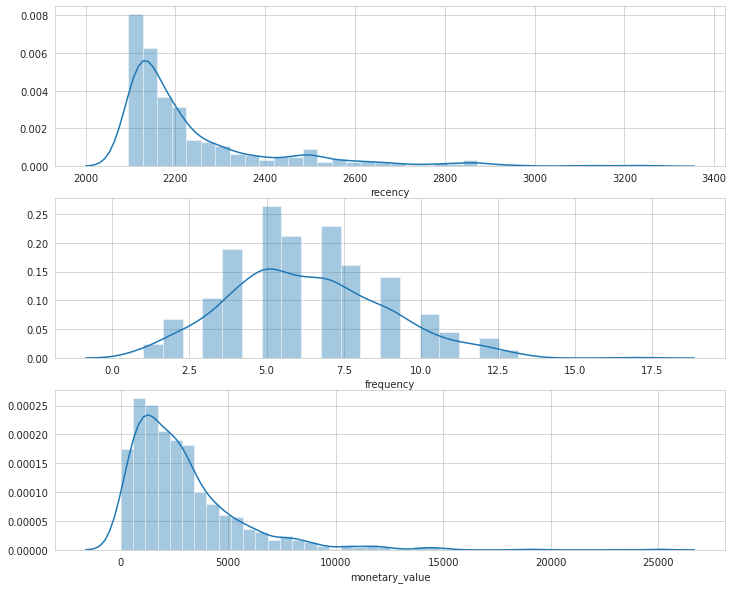

In [486]:

plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(RMF_Segmentation['recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(RMF_Segmentation['frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(RMF_Segmentation['monetary_value'])
# Show the plot
plt.show()

calculating sum of R F M values

In [487]:
RMF_Segmentation['RFM_Score'] = RMF_Segmentation[['R','F','M']].sum(axis=1)
print(RMF_Segmentation['RFM_Score'].head())

customer
Aaron Bergman      6
Aaron Hawkins      6
Aaron Smayling     9
Adam Bellavance    9
Adam Hart          9
Name: RFM_Score, dtype: int64


Assigning Label to each customer according to RFM_Score

In [488]:
def rfm_label(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'




Create a new variable RFM_Level

In [489]:
RMF_Segmentation['RFM_Label'] = RMF_Segmentation.apply(rfm_level, axis=1)

Print the header with top 5 rows to the console

In [490]:
RMF_Segmentation.head()

,recency,frequency,monetary_value,R,F,M,RFMClass,RFM_Score,RFM_Label
customer,,,,,,,,,
Aaron Bergman,2510,3,887,4,1,1,411,6,Potential
Aaron Hawkins,2107,7,1744,1,3,2,132,6,Potential
Aaron Smayling,2183,7,3050,3,3,3,333,9,Can't Loose Them
Adam Bellavance,2149,8,7756,2,3,4,234,9,Can't Loose Them
Adam Hart,2129,10,3249,2,4,3,243,9,Can't Loose Them


#Plotting Them According To RFM_Label

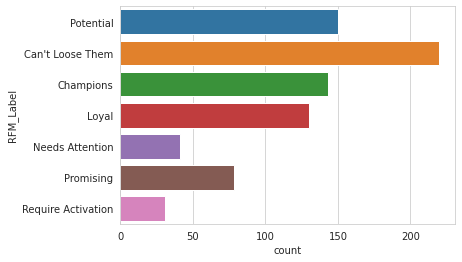

In [491]:
sns.countplot(y='RFM_Label',data=RMF_Segmentation)

*Grouping them By labels*

In [492]:
rfm_level_agg = RMF_Segmentation.groupby('RFM_Label').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean', 'count']
}).round(1)


Print the aggregated dataset

In [493]:
print(rfm_level_agg)

                   recency frequency monetary_value      
                      mean      mean           mean count
RFM_Label                                                
Can't Loose Them    2233.4       8.7         5111.4   220
Champions           2233.7       7.1         3358.1   143
Loyal               2269.9       5.6         2570.8   130
Needs Attention     2135.7       4.0          943.4    41
Potential           2334.6       4.7         1339.4   150
Promising           2162.3       4.6         1304.3    78
Require Activation  2112.1       3.8          548.9    31


In [502]:
RMF_Segmentation['RFM_Label'] = RMF_Segmentation['R'].map(str) + RMF_Segmentation['F'].map(str)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


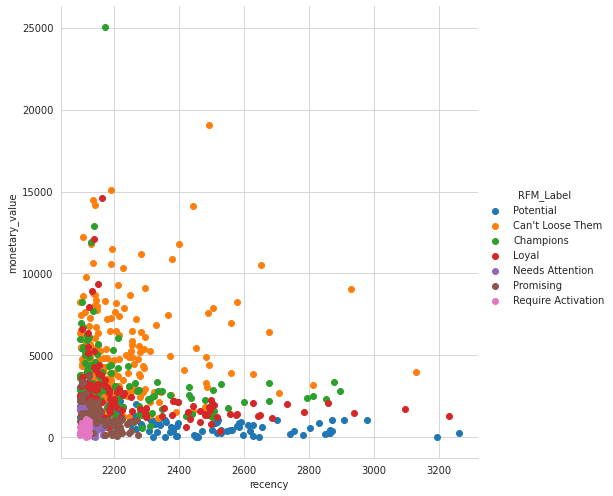

In [495]:
sns.set_style('whitegrid')
sns.FacetGrid(RMF_Segmentation,hue='RFM_Label',size=7)\
.map(plt.scatter,'recency','monetary_value')\
.add_legend();

plt.show()